In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from analysis.metrics_calculation import get_snapshot_complexity
from aggregated_analysis import read_hackathon_data
from analysis_utils import get_sorted_kernels
from sequence_processor.sequence import SequenceProcessor


In [50]:
df = read_hackathon_data()
num = 20
sorted_kernels_df = get_sorted_kernels(df).iloc[:num]
sorted_kernels_df


,kernel_id,0
0,bc147b33-fa74-4bff-9f48-c88809c5bdcd,1569
1,dbe93969-24a0-4ea7-ae94-1737cb070287,1381
2,671c08d4-f227-4f23-b0ac-6842c4187641,1262
3,36c724d9-3a5f-43e2-aba2-2d0933046f35,1211
4,232bcb48-7455-4109-9eeb-809649a6bedc,1100
5,033a2c63-4cfb-4cc5-9988-59c48a06eb23,1092
6,8a599028-9e81-4862-ad7f-15500e742f27,1040
7,3179a989-9b41-49b9-84f8-5fe83a7c65bf,1024
8,29da7c56-5a69-485f-b181-a0a7199a559c,996
9,9b98360e-dcfe-4a13-aa1b-a8fbce65d75d,985


In [51]:

df = df[df.kernel_id.isin(sorted_kernels_df.kernel_id)]
df.head()


,id,ip_address,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,expert
20,21,None,2023-05-06T08:32:26.282Z,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,NaN,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,False
22,23,192.168.56.1,2023-05-06T08:32:55.892Z,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,False
23,24,192.168.56.1,2023-05-06T08:32:56.229Z,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",False
25,26,192.168.56.1,2023-05-06T08:32:58.048Z,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,False
26,27,192.168.56.1,2023-05-06T08:32:58.429Z,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",False


In [52]:
def aggregate_complexity(processor):
    complexities_sum = {
        'ccn': [],
        'sloc': [],
        'objects': []
    }

    complexities_mean = {
        'ccn': [],
        'sloc': [],
        'objects': []
    }

    for snap in tqdm(processor.snapshots[1:]):
        snap.delete_duplicates()
        complexity_dict = get_snapshot_complexity(snap)
        for key in complexities_sum.keys():
            complexities_sum[key].append(complexity_dict[f"{key}_sum"])
            complexities_mean[key].append(complexity_dict[f"{key}_mean"])

    return complexities_sum, complexities_mean


In [53]:

complexities_dict_mean = {}
complexities_dict_sum = {}


for kernel_id, df_sample in df.groupby('kernel_id'):
    df_sample = df_sample.groupby('event').get_group('execute')

    processor = SequenceProcessor(
        df_sample\
        .drop('expert', axis=1)\
        .fillna(np.NaN).replace(np.NaN, None)
    )

    complexities_sum, complexities_mean = aggregate_complexity(processor)
    complexities_dict_mean[kernel_id] = complexities_mean
    complexities_dict_sum[kernel_id] = complexities_sum

100%|██████████| 191/191 [00:00<00:00, 227.79it/s]


In [54]:
grouped = df.groupby('notebook_name')

groups_mapping = {'task1': [], 'task2': []}
for name, group in grouped:
    group_set = set(group.kernel_id.unique())
    if 'task1' in name:
        groups_mapping['task1'] += [name for name in df.kernel_id.unique() if name in group_set]
    elif 'task2' in name:
        groups_mapping['task2'] += [name for name in df.kernel_id.unique() if name in group_set]

groups_mapping

{'task1': ['bc147b33-fa74-4bff-9f48-c88809c5bdcd',
  '29da7c56-5a69-485f-b181-a0a7199a559c',
  '671c08d4-f227-4f23-b0ac-6842c4187641',
  '36c724d9-3a5f-43e2-aba2-2d0933046f35',
  '81607d1b-0c4b-430e-b216-7b91e68a8a9a',
  'd8b51ec1-1385-4b2b-8dd8-76ad8927fba1',
  '0033f76c-6179-4fb4-a9ce-79112a52b51c',
  'dbe93969-24a0-4ea7-ae94-1737cb070287',
  '3e5940c7-5103-426f-86c1-c2b3b2456e19',
  '033a2c63-4cfb-4cc5-9988-59c48a06eb23',
  'f740b64e-0997-4bd5-bdd6-2b47c4251f71'],
 'task2': ['991072d2-8236-4242-9778-1a1d9ac500fa',
  'a6d4d998-4bb4-4011-a768-1d33450442b8',
  '9b98360e-dcfe-4a13-aa1b-a8fbce65d75d',
  '9667b100-9a32-47d0-8e6e-510add5cad00',
  '8a599028-9e81-4862-ad7f-15500e742f27',
  '388ef554-e3e7-4410-89ac-d6ad4aeaec6c',
  '232bcb48-7455-4109-9eeb-809649a6bedc',
  '3179a989-9b41-49b9-84f8-5fe83a7c65bf',
  '3ebfe9c5-4911-4400-a7c6-9d76b74ed979']}

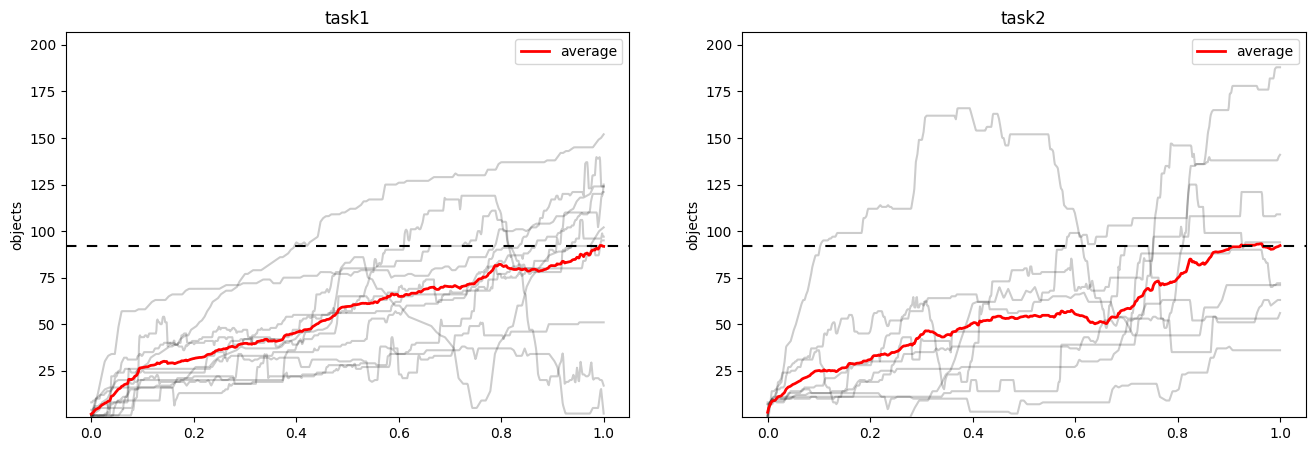

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 8, 5))

complexities_dict = complexities_dict_sum
interpolation_size = 1000
xp = np.linspace(0, 1, interpolation_size)
key = 'objects'

dd = {'task1': 0, 'task2': 1}
mn, mx = np.inf, -np.inf

for group, ids in groups_mapping.items():
    agg = np.zeros(interpolation_size)
    for idx in ids:
        d = complexities_dict[idx]
        y = np.array(d[key])
        y[np.isnan(y)] = 0
        x = np.linspace(0, 1, len(y))

        y = np.interp(xp, x, y) + 1e-5
        if y.min() < mn:
            mn = y.min()
        if y.max() > mx:
            mx = y.max()

        ax[dd[group]].plot(xp, y, color='k', alpha=0.2)
        agg += y

    ax[dd[group]].set_title(group)
    ax[dd[group]].set_ylabel(key)
    ax[dd[group]].plot(xp, agg / len(ids), c='r', lw=2, label='average')
    ax[dd[group]].axhline((agg / len(ids))[-1], color='k', ls=(0, (5, 5)))
    ax[dd[group]].legend()

for axi in ax:
    axi.set_ylim(mn*0.9, mx*1.1)



--- file1
+++ file2
@@ -1,7 +1,7 @@
+cat
 dog
-cat
 bird
 buffalo
-gophers
-hound
+gopher
 horse
+mouse
